In [1]:
%matplotlib inline  
import struct
from struct import unpack
from numpy import zeros, uint8, float32
from pylab import imshow, show, cm
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import subprocess


#Initialize for keras
import keras
from keras.datasets import mnist
from keras.models import Sequential, Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K

Using TensorFlow backend.


In [2]:
# Define functions for reading data.
# Based on https://gist.github.com/tylerneylon/
def read_idx(filename):
    """
        Read from file and create numpy array
    """
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

def get_data(image_file, label_file, num_classes = 10):
    """
        Read the image and label data
    """
    # Read the files
    pre_images = read_idx(image_file)
    pre_labels = read_idx(label_file)
    
    images = np.zeros((len(pre_images), 28,28, 1), dtype=np.float32)
    labels = np.zeros((len(pre_labels),num_classes), dtype=np.int8)
    for i in range(len(pre_images)):
        pre_img=pre_images[i]
        pre_label=pre_labels[i]
        img = (pre_img.transpose() / 255.0)
        images[i] = img.reshape(28,28,1) 
        labels[i] = keras.utils.to_categorical(pre_label, num_classes)
    
    return images, labels

def file_len(fname):
    p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE, 
                                              stderr=subprocess.PIPE)
    result, err = p.communicate()
    if p.returncode != 0:
        raise IOError(err)
    return int(result.strip().split()[0])

In [3]:
train_mapping_file = '/home/carnd/data/emnist/emnist-digits-mapping.txt'
num_classes = file_len(train_mapping_file)
train_image_file = '/home/carnd/data/emnist/emnist-digits-train-images-idx3-ubyte'
train_label_file = '/home/carnd/data/emnist/emnist-digits-train-labels-idx1-ubyte'
train_images, train_labels = get_data(train_image_file, train_label_file,num_classes)
print ('Training Data')
print ('Images Shape: {}'.format(train_images.shape))
print ('Labels Shape: {}'.format(train_labels.shape))

test_image_file = '/home/carnd/data/emnist/emnist-digits-test-images-idx3-ubyte'
test_label_file = '/home/carnd/data/emnist/emnist-digits-test-labels-idx1-ubyte'
test_images, test_labels = get_data(test_image_file, test_label_file,num_classes)
print ('Training Data')
print ('Images Shape: {}'.format(test_images.shape))
print ('Labels Shape: {}'.format(test_labels.shape))

Training Data
Images Shape: (240000, 28, 28, 1)
Labels Shape: (240000, 10)
Training Data
Images Shape: (10000, 28, 28, 1)
Labels Shape: (10000, 10)


Label - 8 : [0 0 0 0 0 0 0 0 1 0] 


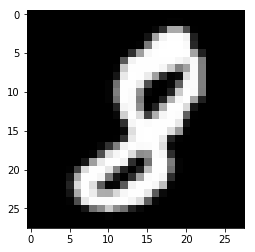

Label - 9 : [0 0 0 0 0 0 0 0 0 1] 


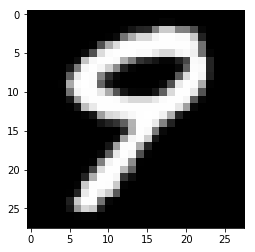

In [4]:
def view_image(image, label=""):
    """View a single image."""
    print("Label - {} : {} ".format(np.argmax(label), label))
    plt.imshow((image.reshape(28,28)), cmap="gray")
    plt.show()

for i in range(2):
    view_image(train_images[i], train_labels[i])

In [5]:
# Train, Test split
from sklearn.model_selection import train_test_split
X_val, X_test, y_val, y_test = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

In [6]:
# Initialize the hyperparameters
input_shape = (28,28, 1)

In [7]:
# Build model
inputs = Input(shape=input_shape)
conv = Conv2D(32, (7, 7), strides=(1, 1), padding='same', name = "conv1", activation='relu')(inputs)
conv = AveragePooling2D((3, 3))(conv)
conv = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name = "conv2", activation='relu')(conv)
conv = AveragePooling2D((2, 2))(conv)
conv = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name = "conv3", activation='relu')(conv)
flat = Flatten()(conv)
dense = Dense(128, activation='relu', name = "dense2")(flat)
dropout = Dropout(0.4)(dense)
outputs = Dense(num_classes, activation='softmax', name = "output")(dropout)

model = Model(inputs=inputs, outputs=outputs)

model.summary()
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Nadam(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        1600      
_________________________________________________________________
average_pooling2d_1 (Average (None, 9, 9, 32)          0         
_________________________________________________________________
conv2 (Conv2D)               (None, 9, 9, 64)          18496     
_________________________________________________________________
average_pooling2d_2 (Average (None, 4, 4, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 4, 4, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
__________

In [8]:
batch_size = 1000
epochs = 50
history = model.fit(train_images, train_labels,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val, y_val))

Train on 240000 samples, validate on 5000 samples
Epoch 1/50
25s - loss: 0.2660 - acc: 0.9167 - val_loss: 0.0450 - val_acc: 0.9856
Epoch 2/50
23s - loss: 0.0489 - acc: 0.9859 - val_loss: 0.0534 - val_acc: 0.9816
Epoch 3/50
23s - loss: 0.0342 - acc: 0.9901 - val_loss: 0.0208 - val_acc: 0.9934
Epoch 4/50
23s - loss: 0.0272 - acc: 0.9922 - val_loss: 0.0181 - val_acc: 0.9946
Epoch 5/50
23s - loss: 0.0238 - acc: 0.9933 - val_loss: 0.0100 - val_acc: 0.9968
Epoch 6/50
23s - loss: 0.0208 - acc: 0.9939 - val_loss: 0.0118 - val_acc: 0.9966
Epoch 7/50
23s - loss: 0.0185 - acc: 0.9947 - val_loss: 0.0104 - val_acc: 0.9968
Epoch 8/50
23s - loss: 0.0170 - acc: 0.9951 - val_loss: 0.0092 - val_acc: 0.9968
Epoch 9/50
23s - loss: 0.0152 - acc: 0.9957 - val_loss: 0.0081 - val_acc: 0.9978
Epoch 10/50
23s - loss: 0.0144 - acc: 0.9960 - val_loss: 0.0089 - val_acc: 0.9978
Epoch 11/50
23s - loss: 0.0132 - acc: 0.9961 - val_loss: 0.0072 - val_acc: 0.9980
Epoch 12/50
23s - loss: 0.0122 - acc: 0.9966 - val_loss: 

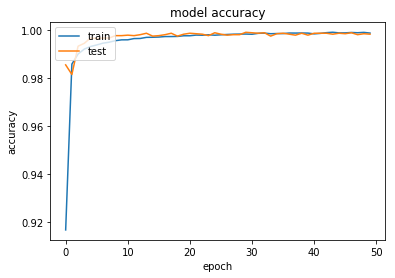

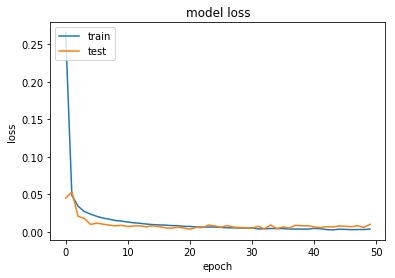

In [9]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
score = model.evaluate(X_test, y_test, verbose=1, batch_size=batch_size)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

5000/5000 [==============================] - 0s     
Test loss: 0.0118432373652
Test accuracy: 0.997600066662
